<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ данных</a></span><ul class="toc-item"><li><span><a href="#Концентрация-металлов" data-toc-modified-id="Концентрация-металлов-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Концентрация металлов</a></span></li><li><span><a href="#Размер-гранул" data-toc-modified-id="Размер-гранул-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Размер гранул</a></span></li><li><span><a href="#Cуммарная-концентрация-веществ" data-toc-modified-id="Cуммарная-концентрация-веществ-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Cуммарная концентрация веществ</a></span></li></ul></li><li><span><a href="#Модель" data-toc-modified-id="Модель-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Модель</a></span><ul class="toc-item"><li><span><a href="#Функция-итоговой-sMAPE" data-toc-modified-id="Функция-итоговой-sMAPE-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Функция итоговой sMAPE</a></span></li><li><span><a href="#Подготовка-данных-к-обучнию-моделей." data-toc-modified-id="Подготовка-данных-к-обучнию-моделей.-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Подготовка данных к обучнию моделей.</a></span></li><li><span><a href="#Выбор-лучшей-модели" data-toc-modified-id="Выбор-лучшей-модели-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Выбор лучшей модели</a></span></li><li><span><a href="#Итоговая-проверка" data-toc-modified-id="Итоговая-проверка-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Итоговая проверка</a></span></li></ul></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

# Восстановление золота из руды

# Постановка задачи

Подготовить прототип модели машинного обучения для [«Цифры»](http://zyfra.com/). Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Будут использоваться данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Нам необходимо:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

# Технологический процесс

Когда добытая руда проходит первичную обработку, получается дроблёная смесь. Её отправляют на флотацию (обогащение) и двухэтапную очистку.

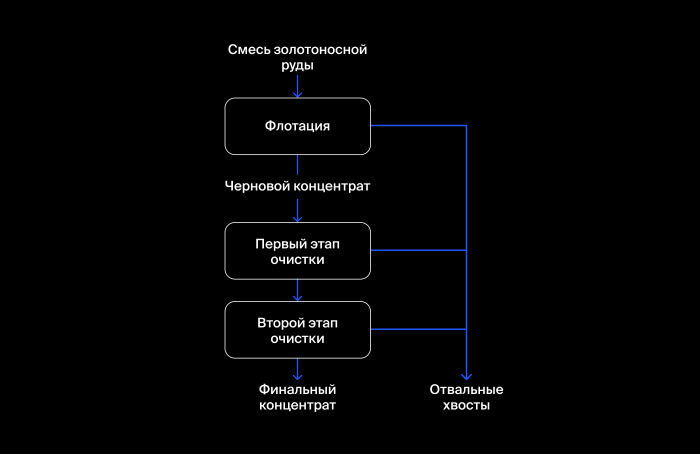

**1. Флотация**

Во флотационную установку подаётся смесь золотосодержащей руды. После обогащения получается черновой концентрат и «отвальные хвосты», то есть остатки продукта с низкой концентрацией ценных металлов.

На стабильность этого процесса влияет непостоянное и неоптимальное физико-химическое состояние флотационной пульпы (смеси твёрдых частиц и жидкости).

**2. Очистка**

Черновой концентрат проходит две очистки. На выходе получается финальный концентрат и новые отвальные хвосты.

# Описание данных

**Технологический процесс**
- Rougher feed — исходное сырье
- Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant
 - Xanthate — ксантогенат (промотер, или активатор флотации);
 - Sulphate — сульфат (на данном производстве сульфид натрия);
 - Depressant — депрессант (силикат натрия).
- Rougher process (англ. «грубый процесс») — флотация
- Rougher tails — отвальные хвосты
- Float banks — флотационная установка
- Cleaner process — очистка
- Rougher Au — черновой концентрат золота
- Final Au — финальный концентрат золота

**Параметры этапов**
- air amount — объём воздуха
- fluid levels — уровень жидкости
- feed size — размер гранул сырья
- feed rate — скорость подачи

# Наименование признаков

Наименование признаков:
`[этап].[тип_параметра].[название_параметра]`

Пример: `rougher.input.feed_ag`

Возможные значения для блока `[этап]`:
- rougher — флотация
- primary_cleaner — первичная очистка
- secondary_cleaner — вторичная очистка
- final — финальные характеристики

Возможные значения для блока `[тип_параметра]`:
- input — параметры сырья
- output — параметры продукта
- state — параметры, характеризующие текущее состояние этапа
- calculation — расчётные характеристики

Данные индексируются датой и временем получения информации (признак `date`). Соседние по времени параметры часто похожи.

## Подготовка данных

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import catboost as cb
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import itertools

import warnings
warnings.filterwarnings('ignore')

In [2]:
RANDOM_STATE = 12345
RANDOM_RANDOM_STATE = np.random.RandomState(RANDOM_STATE)

In [3]:
data_test = pd.read_csv('C:\\Users\\mikha\\Desktop\\Data scince\\Projects\\Data\\Данные СбП 2\\gold_recovery_test_new.csv', 
                       index_col = 'date')
data_full = pd.read_csv('C:\\Users\\mikha\\Desktop\\Data scince\\Projects\\Data\\Данные СбП 2\\gold_recovery_full_new.csv', 
                       index_col = 'date')
data_train = pd.read_csv('C:\\Users\\mikha\\Desktop\\Data scince\\Projects\\Data\\Данные СбП 2\\gold_recovery_train_new.csv', 
                       index_col = 'date')

Выведим общую информацию о данных.

In [4]:
[df.info() for df in [data_test, data_train, data_full]]

<class 'pandas.core.frame.DataFrame'>
Index: 5290 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 52 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   primary_cleaner.input.sulfate               5286 non-null   float64
 1   primary_cleaner.input.depressant            5285 non-null   float64
 2   primary_cleaner.input.feed_size             5290 non-null   float64
 3   primary_cleaner.input.xanthate              5286 non-null   float64
 4   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 5   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 6   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 8   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_level    5290 non-null

[None, None, None]

In [5]:
data_full.head()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,123.819808,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,122.270188,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,117.988169,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


Проверим кол-во пропущенных значений.

In [6]:
print('Общее кол-во пропусков в data_full:',data_full.isnull().sum().sum())
print('Общее кол-во пропусков в data_train:',data_train.isnull().sum().sum())
print('Общее кол-во пропусков в data_test:',data_test.isnull().sum().sum())

Общее кол-во пропусков в data_full: 4481
Общее кол-во пропусков в data_train: 4100
Общее кол-во пропусков в data_test: 90


Данные обновляются с интервалом в 1 час, поэтому в качестве индекса был выбран именно этот столбец.

В некоторых столбцах встречаются пропуски. Т.к. данные обновляются с интервалом в 1 час, уместно будет заполнить пропуски  методом `'ffill'`. Он зполнит пропуски значениями из следующих строк.

Заполним пропуски в `data_full` и других датасетах. Для удобства дальнейшей работы, вернем индексы из `data_full` в тренировочную и тестовую выборки.

In [7]:
data_full = data_full.fillna(method='ffill')

In [8]:
for col in data_test.columns:
    for row in data_test.index:
        if pd.isna(data_test.loc[row,col])==True: 
            data_test.loc[row,col] = data_full.loc[row,col] #заменяем пропуски в тестовой выборке значением из data_full

In [9]:
for col in data_train.columns:
    for row in data_train.index:
        if pd.isna(data_train.loc[row,col])==True:
            data_train.loc[row,col] = data_full.loc[row,col] #заменяем пропуски в тренировочной выборке значением из data_full

Проверим результат

In [10]:
print('Общее кол-во пропусков в data_full:',data_full.isnull().sum().sum())
print('Общее кол-во пропусков в data_train:',data_train.isnull().sum().sum())
print('Общее кол-во пропусков в data_test:',data_test.isnull().sum().sum())

Общее кол-во пропусков в data_full: 0
Общее кол-во пропусков в data_train: 0
Общее кол-во пропусков в data_test: 0


Проверим, что эффективность обогащения рассчитана правильно.

Формула расчета эффективности обогащения:

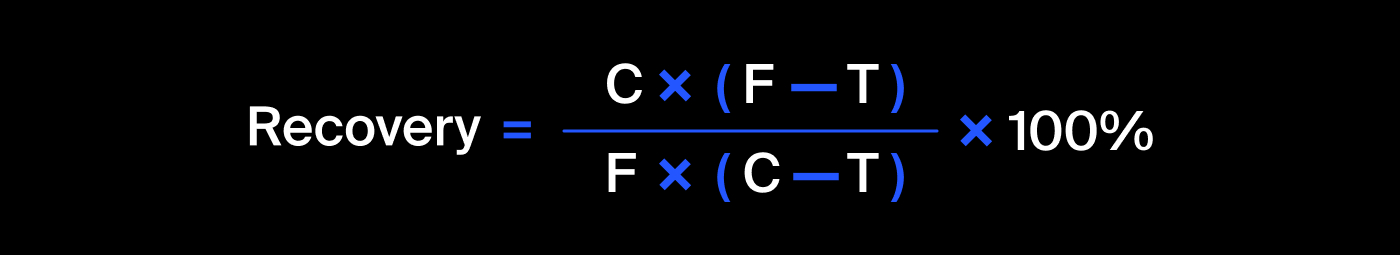

где:

- C — доля золота в концентрате после флотации/очистки;
- F — доля золота в сырье/концентрате до флотации/очистки;
- T — доля золота в отвальных хвостах после флотации/очистки.

In [11]:
full_recovery = []

for r in data_full.index:
    c = data_full.loc[r, 'rougher.output.concentrate_au']
    f = data_full.loc[r, 'rougher.input.feed_au']
    t = data_full.loc[r, 'rougher.output.tail_au']
    full_recovery.append(c*(f-t)/(f*(c-t))*100)
    
mean_absolute_error(data_full['rougher.output.recovery'],full_recovery)    

9.874045668302637e-15

MAE близко к 0. Эффективность обогащения расчитана верно.

Проанализируем признаки, недоступные в тестовой выборке.

In [12]:
[col for col in data_train.columns if col not in data_test.columns]

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'final.output.tail_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.output.tail_au',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.ta

В тестовой выборке недоступны некоторые расчетные (calculation) и выходные (output) характеристики процесса, ведь их невозможно получить либо замерить во время выполнения технологического процесса.

## Анализ данных

### Концентрация металлов

Изучим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки.

Медианая концентрация в Входное сырье = 8.125838836648287
Медианая концентрация в Черн. конц. = 20.280214025891475
Медианая концентрация в Первичная обр. = 32.841295480233306
Медианая концентрация в Конечн. продукт = 45.01124391455689


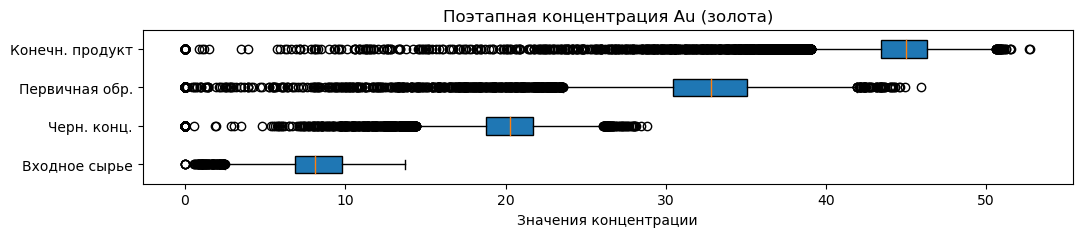

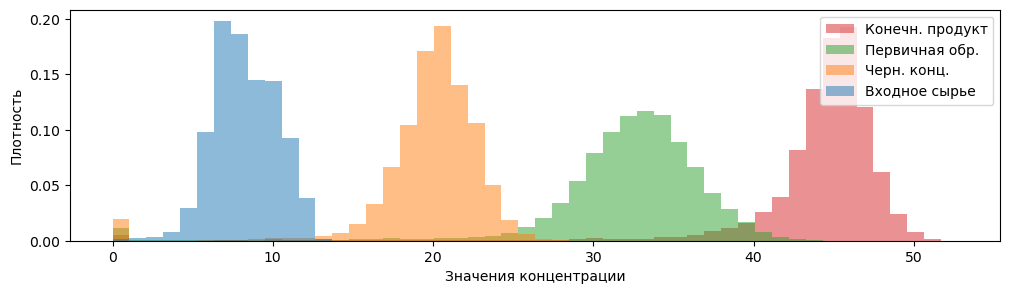

In [13]:
au_concentration_stages = data_full[['rougher.input.feed_au', 'rougher.output.concentrate_au', 
                                     'primary_cleaner.output.concentrate_au', 'final.output.concentrate_au']]
concentration_labels = ['Входное сырье','Черн. конц.', 'Первичная обр.', 'Конечн. продукт']

[print(f'Медианая концентрация в {l} = {c}') for l, c in zip(concentration_labels, list(au_concentration_stages.median()))]

plt.figure(figsize=(12,2))
plt.title("Поэтапная концентрация Au (золота)")
plt.boxplot(au_concentration_stages, labels=concentration_labels, vert=False, patch_artist=True)  
plt.xlabel("Значения концентрации")
plt.show()

plt.figure(figsize=(12,3))
plt.hist(au_concentration_stages, label=concentration_labels, bins=50, alpha = 0.5, histtype='stepfilled', density=True)
plt.legend(loc='upper right')
plt.ylabel("Плотность")
plt.xlabel("Значения концентрации")
plt.show()

От этапа к этапу концентрация золота растет. В этом и есть основная функция предприятия. Скачок от 8% до 45% - впечатляющий результат.

Медианая концентрация в Входное сырье = 8.593574167368724
Медианая концентрация в Черн. конц. = 12.098114967346191
Медианая концентрация в Первичная обр. = 8.507297972365805
Медианая концентрация в Конечн. продукт = 5.066039118467836


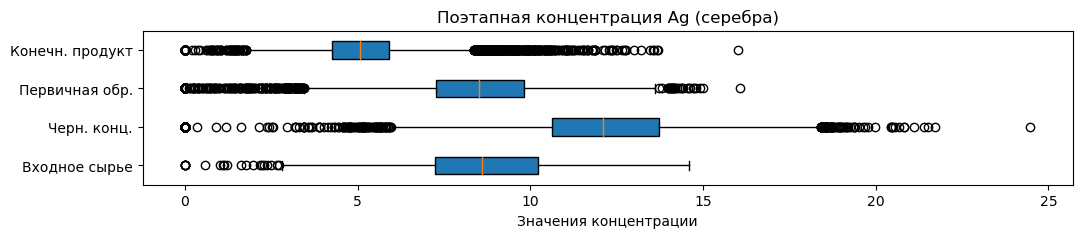

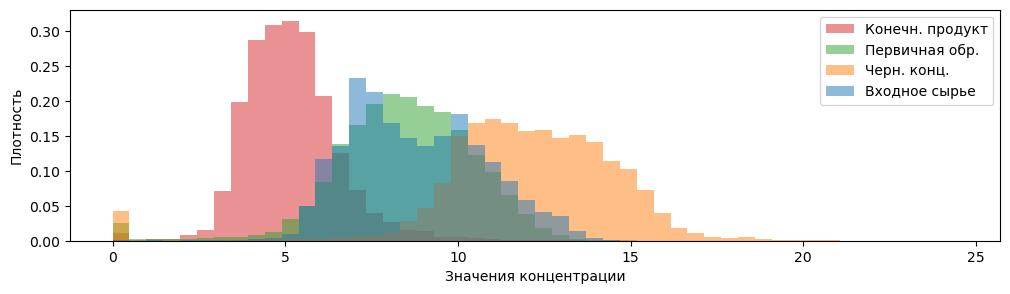

In [14]:
ag_concentration_stages = data_full[['rougher.input.feed_ag', 'rougher.output.concentrate_ag', 
                                     'primary_cleaner.output.concentrate_ag', 'final.output.concentrate_ag']]

[print(f'Медианая концентрация в {l} = {c}') for l, c in zip(concentration_labels, list(ag_concentration_stages.median()))]

plt.figure(figsize=(12,2))
plt.title("Поэтапная концентрация Ag (серебра)")
plt.boxplot(ag_concentration_stages, labels=concentration_labels, vert=False, patch_artist=True)  
plt.xlabel("Значения концентрации")
plt.show()

plt.figure(figsize=(12,3))
plt.hist(ag_concentration_stages, label=concentration_labels, bins=50, alpha = 0.5, histtype='stepfilled', density=True)
plt.legend(loc='upper right')
plt.ylabel("Плотность")
plt.xlabel("Значения концентрации")
plt.show()

А вот концентрация серебра падает. Концентрация серебра на начальном сырье, такая-же как и золота.

Медианая концентрация в Входное сырье = 3.5282347219520145
Медианая концентрация в Черн. конц. = 7.742580079502529
Медианая концентрация в Первичная обр. = 10.142270415359071
Медианая концентрация в Конечн. продукт = 10.10226350598865


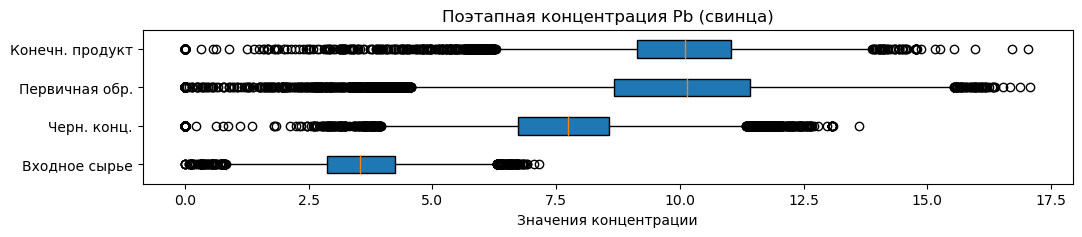

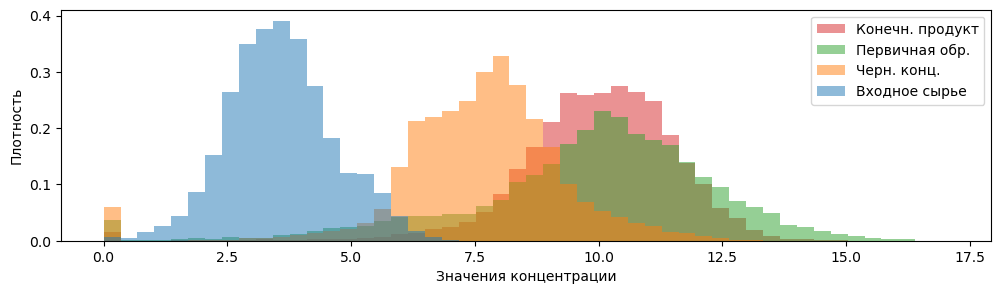

In [15]:
pb_concentration_stages = data_full[['rougher.input.feed_pb', 'rougher.output.concentrate_pb',
                                    'primary_cleaner.output.concentrate_pb', 'final.output.concentrate_pb']]

[print(f'Медианая концентрация в {l} = {c}') for l, c in zip(concentration_labels, list(pb_concentration_stages.median()))]

plt.figure(figsize=(12,2))
plt.title("Поэтапная концентрация Pb (свинца)")
plt.boxplot(pb_concentration_stages, labels=concentration_labels, vert=False, patch_artist=True)  
plt.xlabel("Значения концентрации")
plt.show()

plt.figure(figsize=(12,3))
plt.hist(pb_concentration_stages, label=concentration_labels, bins=50, alpha = 0.5, histtype='stepfilled', density=True)
plt.legend(loc='upper right')
plt.ylabel("Плотность")
plt.xlabel("Значения концентрации")
plt.show()

Во входном сырье концентрация свинца самая низкая. Далее увеличивается и держится примерно на одном уровне. Свинец - это побочный элемент химических реакций, по этой причине немного и увеличивается его концентрация

### Размер гранул

Сравним распределения размеров гранул сырья на обучающей и тестовой выборках

Медианный размер в Тренировочная выборка = 55.269783890501536
Медианный размер в Тестовая выборка = 50.8468431600362


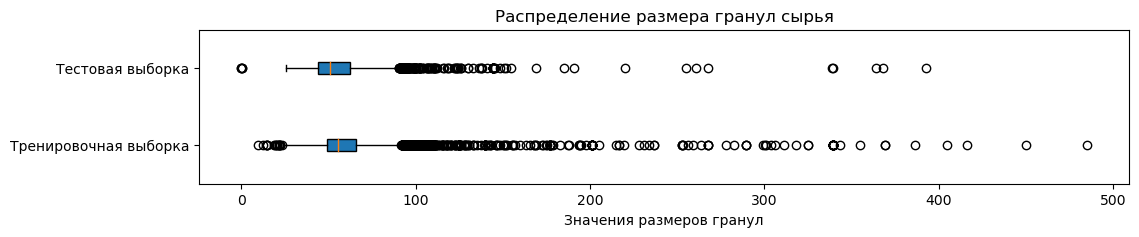

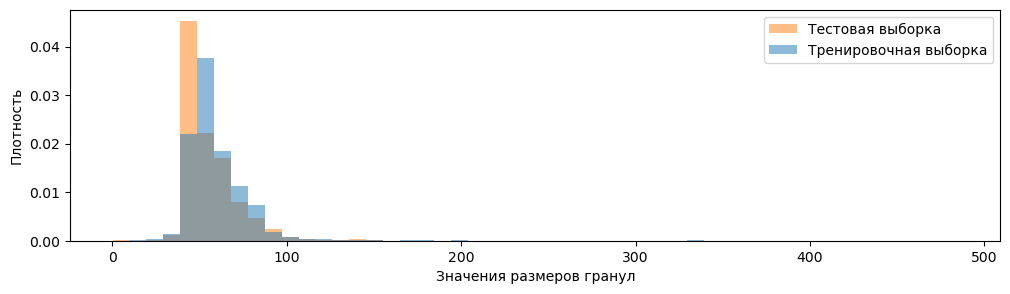

In [16]:
granule_size = [data_train['rougher.input.feed_size'], data_test['rougher.input.feed_size']]
granule_size_labels = ['Тренировочная выборка', 'Тестовая выборка']

[print(f'Медианный размер в {l} = {c.median()}') for l, c in zip(granule_size_labels,granule_size)]

plt.figure(figsize=(12,2))
plt.title("Распределение размера гранул сырья")
plt.boxplot(granule_size, labels=granule_size_labels, vert=False, patch_artist=True)  
plt.xlabel("Значения размеров гранул")
plt.show()

plt.figure(figsize=(12,3))
plt.hist(granule_size, label=granule_size_labels, bins=50, alpha = 0.5, histtype='stepfilled', density=True)
plt.legend(loc='upper right')
plt.ylabel("Плотность")
plt.xlabel("Значения размеров гранул")
plt.show()

Медианный размер гранул отличается не сильно, усы боксплота тоже примерно равны, однако в обеих выборках имеются большие выбросы.

### Cуммарная концентрация веществ

Исследуем суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах

Медианная суммарная концентрация веществ Входное сырье = 57.594391040537595
Медианная суммарная концентрация веществ Черн. конц. = 70.18149499793637
Медианная суммарная концентрация веществ Конечн. продукт = 69.59844443247272


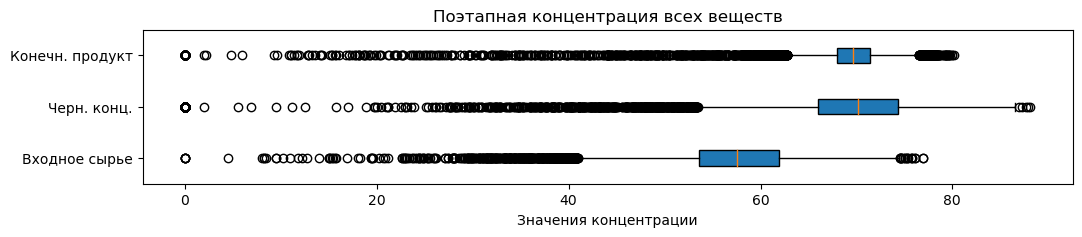

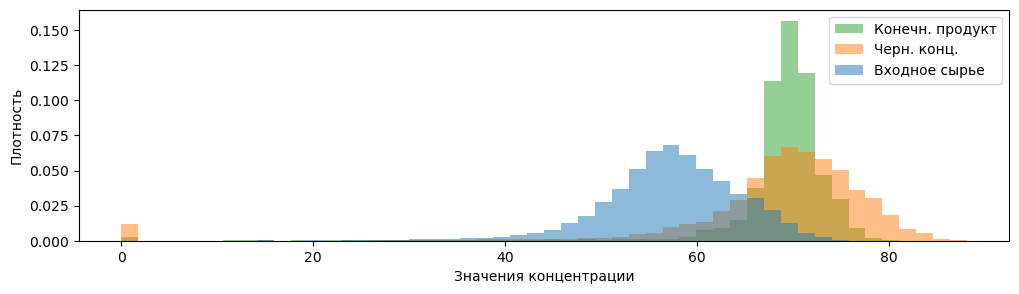

In [17]:
sum_concentrate_0 = data_full['rougher.input.feed_au'] + data_full['rougher.input.feed_ag'] + (
    data_full['rougher.input.feed_pb'] + data_full['rougher.input.feed_sol'])
sum_concentrate_rougher = data_full['rougher.output.concentrate_au'] + data_full['rougher.output.concentrate_ag'] + (
    data_full['rougher.output.concentrate_pb'] + data_full['rougher.output.concentrate_sol'])
sum_concentrate_final = data_full['final.output.concentrate_au'] + data_full['final.output.concentrate_ag'] + (
    data_full['final.output.concentrate_pb'] + data_full['final.output.concentrate_sol'])
sum_concentrate_stages = [sum_concentrate_0, sum_concentrate_rougher, sum_concentrate_final]

total_concentration_labels=['Входное сырье','Черн. конц.', 'Конечн. продукт']

[print(f'Медианная суммарная концентрация веществ {l} = {c.median()}') for l, c in zip(total_concentration_labels, 
                                                                                       sum_concentrate_stages)]
plt.figure(figsize=(12,2))
plt.title("Поэтапная концентрация всех веществ")
plt.boxplot(sum_concentrate_stages, labels=total_concentration_labels, vert=False, patch_artist=True)  
plt.xlabel("Значения концентрации")
plt.show()

plt.figure(figsize=(12,3))
plt.hist(sum_concentrate_stages, label=total_concentration_labels, bins=50, alpha = 0.5, histtype='stepfilled', density=True)
plt.legend(loc='upper right')
plt.ylabel("Плотность")
plt.xlabel("Значения концентрации")
plt.show()

Сначала концентрация веществ находится в районе 60, а в черновом и конечном продукте концентрация веществ держится в районе 70. 
Интересно отметить, что при равных медианах чернового концентрата и конечного продукта, у конечного продукта усы боксплота, примерно, в 2 раза меньше, интерквартильный размах гараздо уже и нету выбросов больше 80%.

Однако, в данном случае, важно удалить аномалии по всем типам суммарных концентраций на обучающей выборке. Ведь отдельно по каждому веществу они могут быть (не всегда есть крупинки золота в руде), а вот суммарно - вряд ли (в руде хоть что-то но будет).

Удалим из тренировочной выборки строки, в которых суммарная концентрация веществ меньше 30, 40, 50 на разных этапах.

In [18]:
for r in data_train.index: #удалим выбросы концентрации всех веществ из входного сырья
    to_drop = np.sum(data_train.loc[r, ['rougher.input.feed_au', 'rougher.input.feed_ag', \
                                        'rougher.input.feed_pb', 'rougher.input.feed_sol']])
    if to_drop < 5:
        data_train = data_train.drop(axis=0, index=r)     

In [19]:
for r in data_train.index: #удалим выбросы концентрации всех веществ из чернового концентрата
    to_drop = np.sum(data_train.loc[r, ['rougher.output.concentrate_au', 'rougher.output.concentrate_ag', \
                                        'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol']])
    if to_drop < 5:
        data_train = data_train.drop(axis=0, index=r)   

In [20]:
for r in data_train.index: #удалим выбросы концентрации всех веществ из конечного продукта
    to_drop = np.sum(data_train.loc[r, ['final.output.concentrate_au', 'final.output.concentrate_ag', \
                                        'final.output.concentrate_pb', 'final.output.concentrate_sol']])
    if to_drop < 5:
        data_train = data_train.drop(axis=0, index=r)   

Определим сколько данных мы удалили.

In [21]:
print('Строк было:', 14149)
print('Строк стало:', len(data_train))
print('Строк удалено:', 14149-len(data_train), 'шт. или', "{:.1%}".format((14149-len(data_train))/14149))

Строк было: 14149
Строк стало: 13787
Строк удалено: 362 шт. или 2.6%


Много, но не критично.

## Модель

### Функция итоговой sMAPE

Для решения задачи будем использовать метрику sMAPE (англ. Symmetric Mean Absolute Percentage Error, «симметричное среднее абсолютное процентное отклонение»).
Она похожа на MAE, но выражается не в абсолютных величинах, а в относительных. Она одинаково учитывает масштаб и целевого признака, и предсказания.

Метрика sMAPE вычисляется так:

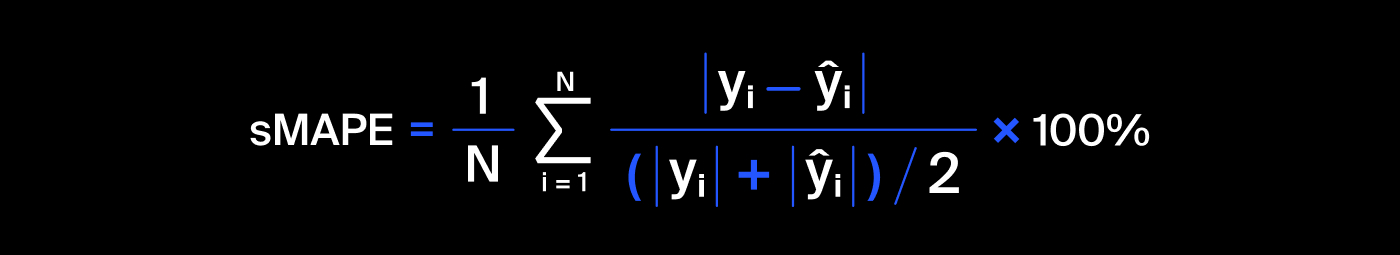

где:

- $y_i$ - значение целевого признака для объекта с порядковым номером i в выборке, на которой измеряется качество;
- $\widehat{y_i}$ - значение предсказания для объекта с порядковым номером i;
- $N$ - количество объектов в выборке;
- $\displaystyle\sum_{i=1}^{N}$ - cуммирование по всем объектам выборки (i меняется от 1 до N).


Напишем функцию для вычисления sMAPE.

In [22]:
def smape(act, forc):
    return 1/ len (act) * np.sum(2 * np.abs(forc-act) / (np.abs(act) + np.abs(forc))*100)

Итоговая метрика складывается из двух величин:

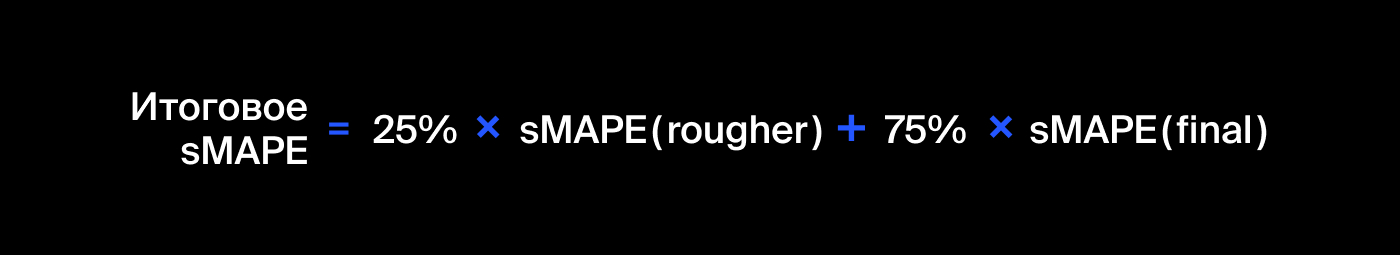

Напишем функцию для вычисления итогового sMAPE.

In [23]:
def final_smape(rou, fin):
    return 0.25*rou + 0.75*fin

### Подготовка данных к обучнию моделей.

Перед нами стоит задача спрогнозировать сразу две величины:
- эффективность обогащения чернового концентрата `rougher.output.concentrate_ag`;
- эффективность обогащения финального концентрата `final.output.concentrate_au`.

И затем вычислить итоговую sMAPE.

Для начала нужно избавиться от столбцов в тренировочной выборке, которые отсутствуют в тестовой.

Для определения каждого целевого признака нужны данные предшествующие этому этапу. Для эффективности обогащения чернового концентрата это только `rougher.input` и `rougher.state`.

In [24]:
features_test_final = data_test.copy()
features_train_final = data_train.drop(axis = 1, 
                                       columns = [col for col in data_train.columns if col not in data_test.columns])

Масштабируем данные.

In [25]:
numeric = [col for col in features_train_final.columns if col in features_test_final.columns]

In [26]:
scaler = StandardScaler()

scaler.fit(data_train[numeric])
features_train_final[numeric] = scaler.transform(data_train[numeric])
features_test_final[numeric] = scaler.transform(data_test[numeric])

Для определения эффективности обогащения чернового концентрата создадим новые датасеты без лишних столбцов.

In [27]:
rougher_col_to_drop = []
for x in features_train_final.columns:
    if not ('rougher.input' in x or 'rougher.state' in x):  
        rougher_col_to_drop.append(x)

In [28]:
features_train_rougher = features_train_final.drop(axis = 1, columns = rougher_col_to_drop)

In [29]:
features_test_rougher = features_test_final.drop(axis = 1, columns = rougher_col_to_drop)

Выберем из `data_full` подходящие целевые показатели для подготовленных признаков.

In [30]:
target_train_rougher = data_train.merge(data_full[['rougher.output.concentrate_au']], how = 'inner', on= 'date')
target_train_rougher = target_train_rougher['rougher.output.concentrate_au_x']

In [31]:
target_test_rougher = data_test.merge(data_full[['rougher.output.concentrate_au']], how = 'inner', on= 'date')
target_test_rougher = target_test_rougher['rougher.output.concentrate_au']

In [32]:
target_train_final = data_train.merge(data_full[['final.output.concentrate_au']], how = 'inner', on= 'date')
target_train_final = target_train_final['final.output.concentrate_au_x']

In [33]:
target_test_final = data_test.merge(data_full[['final.output.concentrate_au']], how = 'inner', on= 'date')
target_test_final = target_test_final['final.output.concentrate_au']

### Выбор лучшей модели

Для выполнения нашей задачи нужна модель, которая будет одинаково хорошо справляться с определением как чернового, так и финального концентрата. Метрикой для моделей будет sMAPE.

Подберем гиперпараметры для модели **Дерева решений**.

In [34]:
best_tree_result = 100
best_tree_depth = 0

for depth in range(1, 10):
    tree_model = DecisionTreeRegressor(random_state=RANDOM_STATE, max_depth=depth)
    tree_predictions_final = cross_val_predict(tree_model, features_train_final, target_train_final, cv=3)
    tree_result_final = smape(target_train_final, tree_predictions_final)
    tree_predictions_rougher = cross_val_predict(tree_model, features_train_rougher, target_train_rougher, cv=3)
    tree_result_rougher = smape(target_train_rougher, tree_predictions_rougher)    
    tree_result = final_smape(tree_result_rougher, tree_result_final)
    if tree_result < best_tree_result:
        best_tree_result = tree_result
        best_tree_depth = depth
        
best_tree_model = DecisionTreeRegressor(random_state=RANDOM_STATE, max_depth=best_tree_depth)
       
print ("Средний sMAPE наилучшей модели:", best_tree_result)   
print ("Максимальная глубина:", round(best_tree_depth, 2)) 

Средний sMAPE наилучшей модели: 7.092939433858742
Максимальная глубина: 3


Подберем гиперпараметры для модели **Catboost**.

In [35]:
best_cat_result = 20000
best_cat_lr = 0
best_cat_deapth = 0
best_cat_iterations = 0
best_cat_model = None

for lr in [0.1, 0.3, 0.5]:
    for dp in [1, 5, 10]:
        for itr in [25, 50, 100]:
            cat_model = cb.CatBoostRegressor(random_state=RANDOM_STATE, loss_function='RMSE', 
                                             iterations=itr, depth=dp, learning_rate=lr, verbose=0)
            cat_predictions_final = cross_val_predict(cat_model, features_train_final, target_train_final, cv=3)
            cat_result_final = smape(target_train_final, cat_predictions_final)
            cat_predictions_rougher = cross_val_predict(cat_model, features_train_rougher, target_train_rougher, cv=3)
            cat_result_rougher = smape(target_train_rougher, cat_predictions_rougher)
            cat_result = final_smape(cat_result_rougher, cat_result_final)        
            if cat_result < best_cat_result:
                best_cat_model = cat_model
                best_cat_result = cat_result
                best_cat_deapth = dp
                best_cat_iterations = itr
                best_cat_lr = lr

            
print ("Средний sMAPE модели:", round(best_cat_result, 2))   
print ("Максимальная глубина:", best_cat_deapth)
print ("Количество итераций:", best_cat_iterations) 
print ("Скорость обучения:", best_cat_lr)

Средний sMAPE модели: 6.78
Максимальная глубина: 1
Количество итераций: 100
Скорость обучения: 0.1


Узнаем результаты модели **Линейной регрессии**.

In [36]:
linear_model = LinearRegression() 
linear_predictions_final = cross_val_predict(linear_model, features_train_final, target_train_final, cv=3)
linear_result_final = smape(target_train_final, linear_predictions_final)
linear_predictions_rougher = cross_val_predict(linear_model, features_train_rougher, target_train_rougher, cv=3)
linear_result_rougher = smape(target_train_rougher, linear_predictions_rougher)
linear_result = final_smape(linear_result_rougher, linear_result_final)

print ("Средний sMAPE модели:", round(linear_result, 2)) 

Средний sMAPE модели: 8.36


У моделей Линейной регрессии и Catboost самые лучшие показатели, но Линейная регрессия работает в разы быстрее, поэтому будем использовать именно ее для итоговой проверки.

### Итоговая проверка

Пришло время итоговой проверки. Проверим лучшую модель на тестовой выборке.

In [40]:
linear_model.fit(features_train_final, target_train_final)
final_test_predictions =  linear_model.predict(features_test_final)

linear_model.fit(features_train_rougher, target_train_rougher)
rougher_test_predictions =  linear_model.predict(features_test_rougher)

final_result = final_smape(smape(target_test_rougher,rougher_test_predictions),\
                           smape(target_test_final,final_test_predictions))

print ("sMAPE на тестовой выборке:", round(final_result, 2)) 

sMAPE на тестовой выборке: 8.35


Итоговое симметричное среднее отклонение равно 8.35%.

Сравним этот показатель с константной моделью.

In [38]:
constant_test_final = [target_test_final.mean()]*len(target_test_final)
constant_test_rougher = [target_test_rougher.mean()]*len(target_test_rougher)

constant_final_result = final_smape(smape(target_test_rougher,constant_test_rougher),\
                                    smape(target_test_final,constant_test_final))

print ("sMAPE константной модели:", round(constant_final_result, 2))

sMAPE константной модели: 8.42


## Вывод

  Перед нами стояла задача создать модель, которая сможет предсказать коэффициент восстановления золота из золотосодержащей руды. Модель со своей задачей справляется, но работает немногим лучше константной модели. Так скажем, есть куда расти. 
  
  Исследование данных привело к выводу, что предоставленные заказачиком данные являются недостоверными. Следует обратить внимание на корректность концентраций и имеющиеся пропуски. Так-же стоит обратить внимание на аномальные значения, уточнить у технолога, нормальны ли такие выбросы. Судя по гистрограмме концентрации металлов, напрашивается вывод, что имеется явная ошибка, нулевые значения концентрации в руде возможны, но они явно выходят за рамки нормального распределения. 
  
  Для финального тестирования была выбрана модель линейной т.к. использует все признаки, в отличие от одноуровневого решающего дерева, поэтому будет более устойчивым при различных сочетаниях признаков. И работает в разы быстрее, чем модель Catboost.
  
  Итоговая sMAPE при тестировании модели линейной регресии составила 8.35%

*Проект окончен.*

***Спасибо за уделенное работе время!***